In [1]:
%matplotlib inline

import seaborn as sns
import tools
import pandas as pd
import numpy as np
import pysal as ps
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio

sns.set(style="whitegrid")

P_THR = 0.05
PERM = 999

## Data

---

**IMPORTANT**: data are not distributed are they were provided by a telecom on the agreement not to be distributed. The code shown here is to provide the approach taken and runs on the used data.

---

Path to the two files required:

1.

In [2]:
shp_link = '../data/a10_agg_maxp_9999/a10_agd_maxp.shp'

Which points to the geometries and activity of the antenna catchment areas.

**NOTE**: this is slightly different from the original file received from the telecom as some of the areas where extremely small and their densities were distorting the results. The approach was to merge them to contiguous areas with the closest possible density. Code used for this aggregation is available in `run_daily.ipynb`.

2.

In [3]:
tif_link = '../data/a10_agg_maxp_9999/adam.tiff'

Which is a raster with context tiles from Stamen, downloaded using [`contextily`](https://github.com/darribas/contextily).

---

Read up files:

* Geometries and values

In [4]:
agg = gpd.read_file(shp_link).set_index('index')

* Tiles

In [5]:
rtr = rio.open(tif_link)
img = np.array([ band for band in rtr.read() ]).transpose(1, 2, 0)
bb = rtr.bounds
l, b, r, t = bb.left, bb.bottom, bb.right, bb.top

* Build spatial weights matrix

In [6]:
w = ps.queen_from_shapefile(shp_link, idVariable='index')

---

Overall distribution of total values:

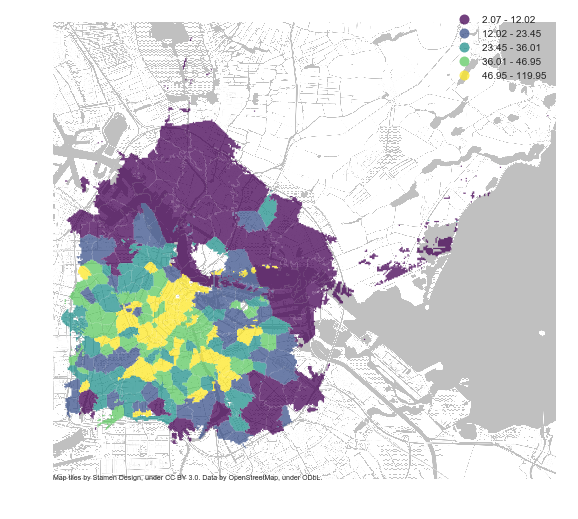

In [7]:
f, ax = plt.subplots(1, figsize=(9, 9))
ax.imshow(img, extent=(l, r, b, t), alpha=0.25)
agg.to_crs(epsg=3857).plot(column='erldens', scheme='quantiles', \
         legend=True, cmap='viridis', linewidth=0, alpha=0.75, ax=ax)
ax.text(l, b, 'Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.', size=7)
ax.set_axis_off()
plt.axis('equal')
plt.show()

`erldens` (calculated in `run_daily.ipynb`) is the average `trafficerlang` over the entire period, summed by grouped areas, and divided by the area of the polygon. Assuming every grouped areas have the same observations over time, they are equivalent. For two observations $i$ and $j$:

$$
\dfrac{1}{T} \sum_t{e_{it}} + \dfrac{1}{T} \sum_t{e_{jt}} = \dfrac{1}{T} \sum_t{e_{it} + e_{it}}
$$

This means we can use the `erldens` provided in `agg` for the LISA figure.

## Cross-sectional LISA

LISA:

In [8]:
np.random.seed(1234)
w.transform = 'R'
lisa = ps.Moran_Local(agg['erldens'].reindex(w.id_order).values, w, \
               permutations=PERM)

Significance:

In [9]:
sign = lisa.p_sim < P_THR
quadS = pd.Series(lisa.q * sign, index=w.id_order)
quadS.name = 'LISA'
quadS.index.name = 'index'
quadScl = pd.DataFrame(quadS.map(tools.lisaclasss))
quadScl.head()

,LISA
index,
a0,HH
a1,N/A
a10,N/A
a100,N/A
a101,N/A


In [10]:
quadScl.to_csv(shp_link.replace('.shp', '_csLISA.csv'))

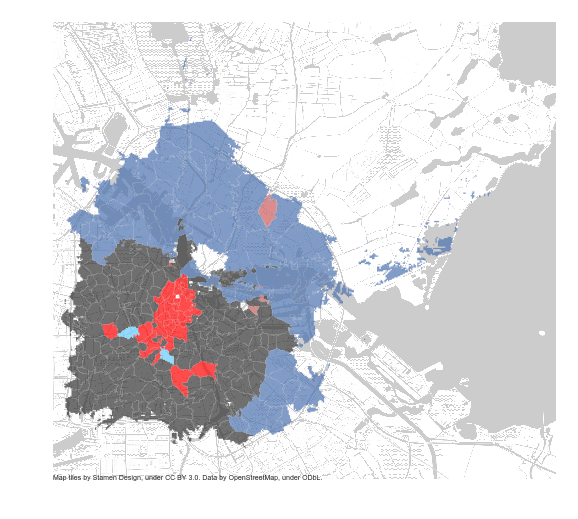

In [11]:
f, ax = plt.subplots(1, figsize=(9, 9))
ax.imshow(img, extent=(l, r, b, t), alpha=0.2)

#quadH = quadS.replace(2, 0).replace(3, 0)
quadH = quadS
colors = tools.lisacD
colors[0] = '0.2'

for c in colors:
    tmp = agg.to_crs(epsg=3857).loc[quadH==c]
    tmp.plot(color=tools.lisacD[c], \
             ax=ax, linewidth=0.1, edgecolor='0.8', alpha=0.7)

ax.text(l, b, 'Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.', size=7)
ax.set_axis_off()
plt.axis('equal')
plt.savefig('/home/dani/Desktop/lisa_cs.png', dpi=300, bbox_inches='tight', \
                        pad_inches=0)
plt.show()

## Cross-sectional Scan

This section uses a bespoke interface written in Python (and available in `tools.py`) to interact with `SaTScan`. It requires you have a `SaTScan` executable on your machine and you link to it by providing the path in `tools.py` (L.37).

* High values

In [12]:
y = agg['erldens'].reindex(w.id_order)
sc = tools.scan(pd.DataFrame({0: y}).stack(),
               shp_link.replace('.shp', '_wgs84.shp'), 'index', weight=None,
               tpl_link='satscan_template_normal_spatial.prm', stype=1,
               sp_only=True, int_ids=False)

No weights specified

Process sent to SaTScan, computing...

Job finished:
	CAS file in ../data/a10_agg_maxp_9999/a10_agd_maxp_wgs84_temp.cas
	GEO file in ../data/a10_agg_maxp_9999/a10_agd_maxp_wgs84_temp.geo
	PRM file in../data/a10_agg_maxp_9999/a10_agd_maxp_wgs84_temp.prm
Total time: 0.04 minutes

SaTScan output info
...
Cluster 1 info:
	N. of observations: 83
	
SaTScan files removed


* Low values

In [13]:
y = agg['erldens'].reindex(w.id_order)
sc_low = tools.scan(pd.DataFrame({0: y}).stack(),
               shp_link.replace('.shp', '_wgs84.shp'), 'index', weight=None,
               tpl_link='satscan_template_normal_spatial.prm', stype=2,
               sp_only=True, int_ids=False)

No weights specified

Process sent to SaTScan, computing...

Job finished:
	CAS file in ../data/a10_agg_maxp_9999/a10_agd_maxp_wgs84_temp.cas
	GEO file in ../data/a10_agg_maxp_9999/a10_agd_maxp_wgs84_temp.geo
	PRM file in../data/a10_agg_maxp_9999/a10_agd_maxp_wgs84_temp.prm
Total time: 0.05 minutes

SaTScan output info
...
Cluster 1 info:
	N. of observations: 44
	
SaTScan files removed


* Plot

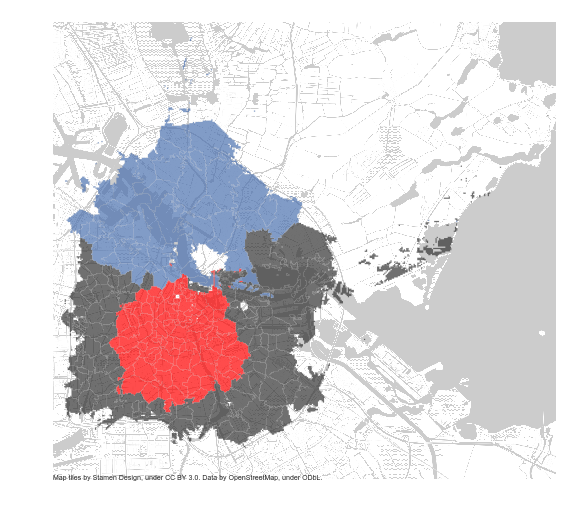

In [14]:
sc[sc_low==1] = 3

f, ax = plt.subplots(1, figsize=(9, 9))
ax.imshow(img, extent=(l, r, b, t), alpha=0.2)

for c in tools.lisacD:
    tmp = agg.to_crs(epsg=3857).loc[sc[0]==c]
    if tmp.shape[0] > 0:
        tmp.plot(color=tools.lisacD[c], \
                 ax=ax, linewidth=0.1, edgecolor='0.8', alpha=0.7)

ax.text(l, b, 'Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.', size=7)
ax.set_axis_off()
plt.axis('equal')
plt.savefig('/home/dani/Desktop/scan_cs.png', dpi=300, bbox_inches='tight', \
                        pad_inches=0)
plt.show()

## Average day

In [15]:
def pip(pt, polys):
    for id, poly in polys.iteritems():
        if poly.contains(pt):
            return id
# Obtain cross-walk between original `a10` 
# and Max-P `a10` geographies
a10 = gpd.read_file('../data/a10/a10.shp')
a10 = a10.to_crs(agg.crs)
a10p = a10.set_index('GRIDCODE')['geometry'].representative_point()
%time cw = a10p.apply(pip, \
                polys=agg['geometry'])
cw.name = 'maxp_lbl'
# Average daily volume by hour
db = pd.read_csv('../data/for_dani.csv')
db = db.join(cw, on='gridcode')
er_mp = db.groupby(['maxp_lbl', 'time']).sum()['erlang']
# Areas in Sq. Km (from sq. m)
areas = agg['geometry'].area * 1e-6
areas.name = 'area'
er_mp = er_mp.reset_index().join(areas, on='maxp_lbl')
er_mp['erdens'] = er_mp['erlang'] / er_mp['area']
er_mp.head(3)

CPU times: user 244 ms, sys: 0 ns, total: 244 ms
Wall time: 242 ms


,maxp_lbl,time,erlang,area,erdens
0,a0,0,3.676525,0.088,41.778693
1,a0,1,2.207007,0.088,25.079625
2,a0,2,1.277083,0.088,14.512307


### Repeated cross-section LISA

* Computation

In [16]:
np.random.seed(1234)

db = er_mp.set_index(['maxp_lbl', 'time'])['erdens'].unstack()
w.transform = 'R'
lisa_db = {}
for h in db.columns:
    y = db.loc[w.id_order, h].values
    lisa = ps.Moran_Local(y, w, permutations=PERM)
    sign = lisa.p_sim < P_THR
    quadS = pd.Series(lisa.q * sign,
                      index=w.id_order)
    lisa_db[h] = quadS
lisa_db = pd.DataFrame(lisa_db)

* Visualization

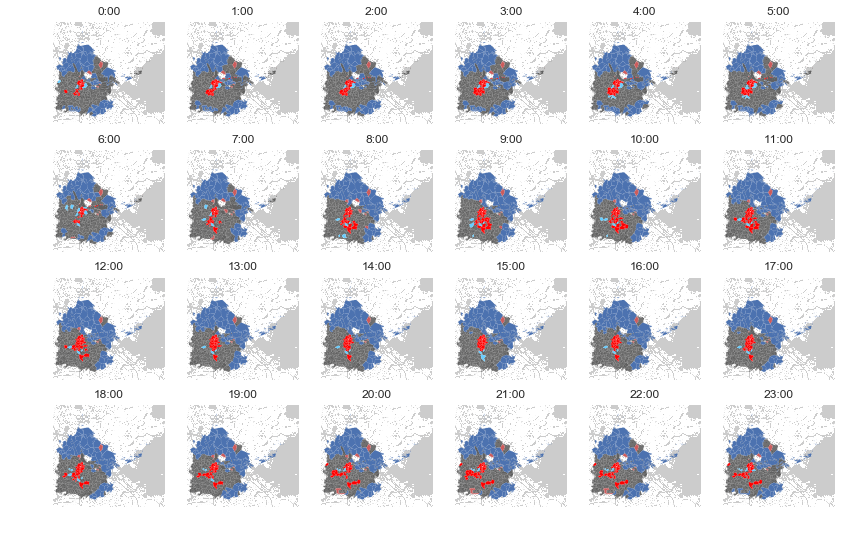

CPU times: user 1min 27s, sys: 168 ms, total: 1min 27s
Wall time: 1min 27s


In [17]:
%%time

f = plt.figure(figsize=(14, 9))
r, c = (4, 6)
agg_p = agg.to_crs(epsg=3857)
for i, col in enumerate(lisa_db):
    ax = f.add_subplot(r, c, i+1)
    ax.imshow(img, extent=(bb.left, bb.right, bb.bottom, bb.top), alpha=0.2)
    hlisa = lisa_db[col]#.replace(2, 0).replace(3, 0)
    for q in colors:
        tmp = agg_p.assign(hlisa=hlisa).loc[hlisa==q]
        alpha=0.7
        if q != 0:
            alpha=1.
        tmp.plot(color=colors[q], \
                 ax=ax, linewidth=0, alpha=alpha)
    ax.set_title('%i:00'%col)
    ax.set_axis_off()
    plt.axis('equal')

plt.savefig('/home/dani/Desktop/rcs-lisa.png', dpi=300)
plt.show()

### ST-LISA

* Space-Time weights matrix

In [18]:
w.transform = 'O'
ts = er_mp['time'].unique().shape[0]
stw = tools.w_stitch_single(w, ts)
stw.transform = 'R'

* Computation

In [19]:
y = er_mp.set_index(['time', 'maxp_lbl'])\
                                 .sortlevel('time')\
                                 ['erdens']


stw.transform = 'R'
lisa = ps.Moran_Local(y.values, stw, permutations=99)
sign = lisa.p_sim < 0.05
quadS = pd.Series(lisa.q * sign, y.index)
lisa24 = quadS.swaplevel(0, 1)\
              .unstack()\
              .reindex(columns=range(24))

/home/dani/anaconda/envs/stc/lib/python3.5/site-packages/ipykernel_launcher.py:1: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  """Entry point for launching an IPython kernel.


* Visualization

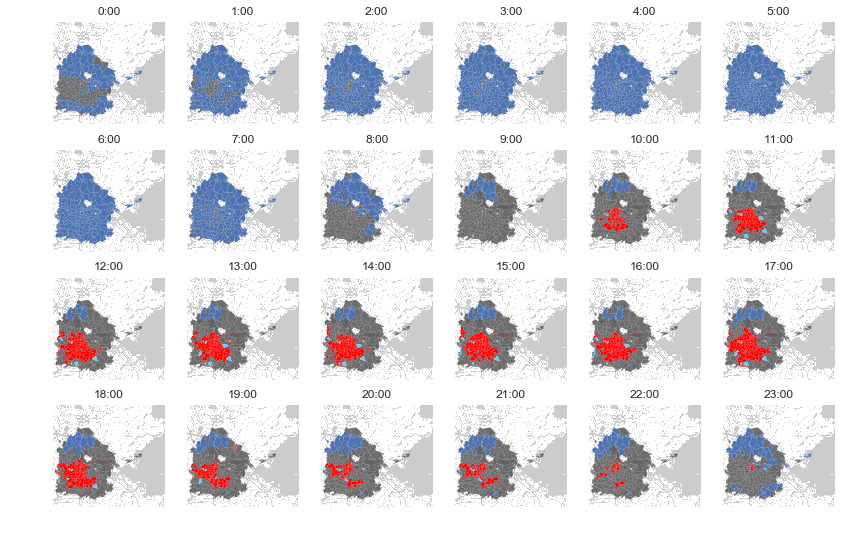

CPU times: user 59.6 s, sys: 56 ms, total: 59.7 s
Wall time: 59.7 s


In [20]:
%%time

f = plt.figure(figsize=(14, 9))
r, c = (4, 6)
agg_p = agg.to_crs(epsg=3857)
for i, col in enumerate(lisa24):
    ax = f.add_subplot(r, c, i+1)
    ax.imshow(img, extent=(bb.left, bb.right, bb.bottom, bb.top), alpha=0.2)
    hlisa = lisa24[col]#.replace(2, 0).replace(3, 0)
    for q in colors:
        tmp = agg_p.assign(hlisa=hlisa).loc[hlisa==q]
        alpha=0.7
        if q != 0:
            alpha=1.
        if tmp.shape[0] > 0:
            tmp.plot(color=tools.lisacD[q], \
                     ax=ax, linewidth=0, alpha=alpha)
    ax.set_title('%i:00'%col)
    ax.set_axis_off()
    plt.axis('equal')

plt.savefig('/home/dani/Desktop/st-lisa.png', dpi=300)
plt.show()

## Calendars

Load up LISA results computed in `run_daily.ipynb`:

In [21]:
lisas = pd.read_csv('../data/lisa_clusters_9999p.csv', index_col=0)
lisas = lisas.rename(columns=pd.to_datetime)\
             .sort_index(axis=1)
lisas.index = pd.MultiIndex.from_tuples(\
            pd.Series(lisas.index.values).apply(lambda x: x.split('-')), \
            names=['Hour', 'gridcode']
                                        )
contour = agg.unary_union

---

* Zuid

<iframe width="425" height="350" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="http://www.openstreetmap.org/export/embed.html?bbox=4.895524978637695%2C52.36058455924514%2C4.9063825607299805%2C52.39419659749338&amp;layer=mapnik" style="border: 1px solid black"></iframe><br/><small><a href="http://www.openstreetmap.org/#map=15/52.3774/4.9010">View Larger Map</a></small>

In [22]:
from importlib import reload
reload(tools);

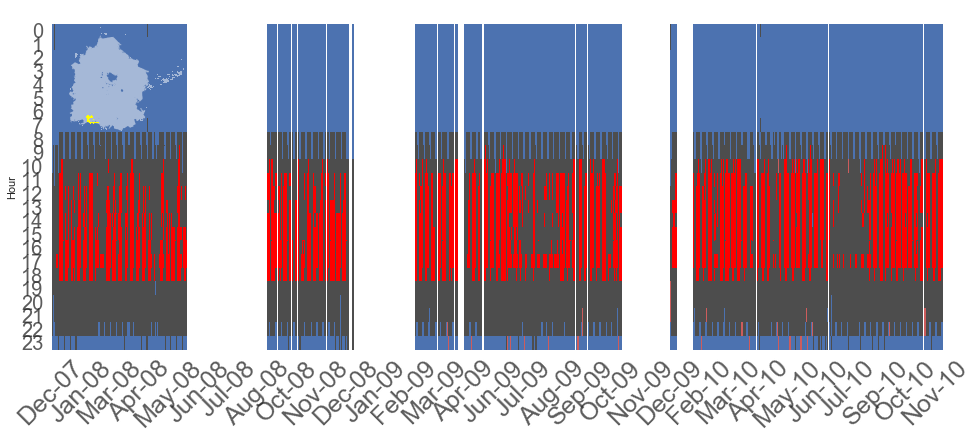

In [23]:
f, ax = plt.subplots(1, figsize=(16, 6))
tools.area_hm('a58', lisas.resample('d', axis=1).mean(), \
              contour=contour, shp=agg, linewidths=0, \
              title=' ', ax=ax, f=f)
plt.savefig('/home/dani/Desktop/zuid.png', \
            dpi=300, transparent=True, bbox_inches='tight', \
                        pad_inches=0)

Check if there there is a weekend pattern:

In [24]:
arid = 'a58'
ar = lisas.xs(arid, axis=0, level='gridcode')
ct_cl = lambda d: d[d==1].sum()
counts = ar.apply(ct_cl, axis=0)
counts = pd.DataFrame({'reds': counts})
counts['dow'] = pd.Series(counts.index, index=counts.index)\
                  .apply(lambda x: x.dayofweek)
counts['weekend'] = (counts['dow'] == 5) | (counts['dow'] == 6)
print('Zuid: Average N. of reds in a day')
counts.groupby('weekend').mean()['reds']

Zuid: Average N. of reds in a day


weekend
False    4.638932
True     0.000000
Name: reds, dtype: float64

---

* Leidseplein

<iframe width="425" height="350" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="http://www.openstreetmap.org/export/embed.html?bbox=4.881019592285156%2C52.36156079549556%2C4.882376790046692%2C52.36576360657919&amp;layer=cyclemap" style="border: 1px solid black"></iframe><br/><small><a href="http://www.openstreetmap.org/#map=18/52.36366/4.88170&amp;layers=C">View Larger Map</a></small>

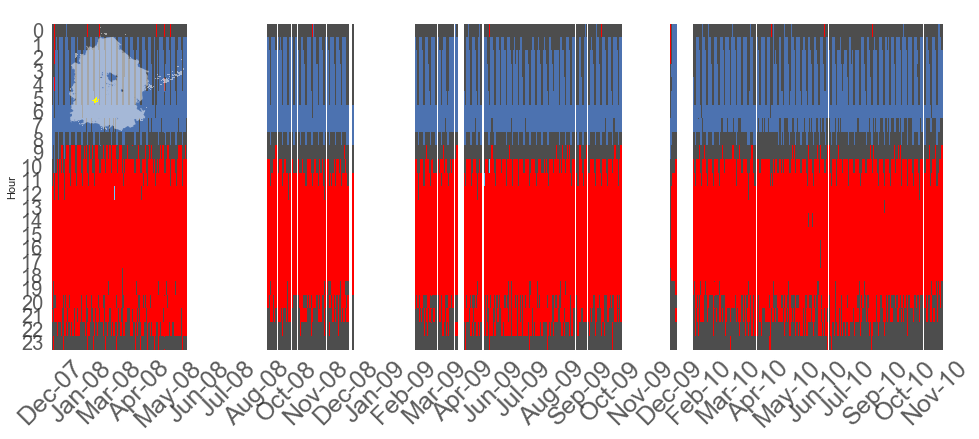

In [25]:
f, ax = plt.subplots(1, figsize=(16, 6))
tools.area_hm('a74', lisas.resample('d', axis=1).mean(), \
              contour=contour, shp=agg, linewidths=0, \
              title=' ', ax=ax, f=f)
plt.savefig('/home/dani/Desktop/leidseplein.png', \
            dpi=300, transparent=True, bbox_inches='tight', \
                        pad_inches=0)

---

* Bos en Lommerplein

<iframe width="425" height="350" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="http://www.openstreetmap.org/export/embed.html?bbox=4.843865633010864%2C52.37373900367776%2C4.8465800285339355%2C52.382141909098245&amp;layer=mapnik" style="border: 1px solid black"></iframe><br/><small><a href="http://www.openstreetmap.org/#map=17/52.37794/4.84522">View Larger Map</a></small>

In [26]:
from importlib import reload
reload(tools);

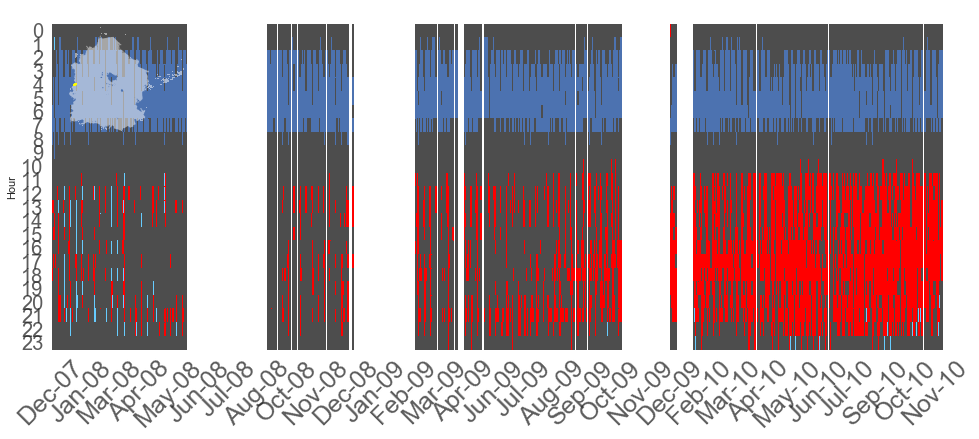

In [27]:
f, ax = plt.subplots(1, figsize=(16, 6))
tools.area_hm('a111', lisas.resample('d', axis=1).mean(), \
              contour=contour, shp=agg, linewidths=0, \
              title=' ', ax=ax, f=f)
plt.savefig('/home/dani/Desktop/bosenlommerplein.png', \
            dpi=300, transparent=True, bbox_inches='tight', \
                        pad_inches=0)

In [28]:
arid = 'a111'
ar = lisas.xs(arid, axis=0, level='gridcode')
ct_cl = lambda d: d[d==1].sum()
counts = ar.apply(ct_cl, axis=0)
counts = pd.DataFrame({'reds': counts})
counts['dow'] = pd.Series(counts.index, index=counts.index)\
                  .apply(lambda x: x.dayofweek)
counts['weekend'] = (counts['dow'] == 5) | (counts['dow'] == 6)
print('Bos en Lommerplein: Average N. of reds in a day')
counts.groupby('weekend').mean()['reds']

Bos en Lommerplein: Average N. of reds in a day


weekend
False    2.725275
True     5.816000
Name: reds, dtype: float64

---

* Andreasplein

<iframe width="425" height="350" frameborder="0" scrolling="no" marginheight="0" marginwidth="0" src="http://www.openstreetmap.org/export/embed.html?bbox=4.844745397567749%2C52.352832871067314%2C4.84745979309082%2C52.361239753739746&amp;layer=mapnik" style="border: 1px solid black"></iframe><br/><small><a href="http://www.openstreetmap.org/#map=17/52.35704/4.84610">View Larger Map</a></small>

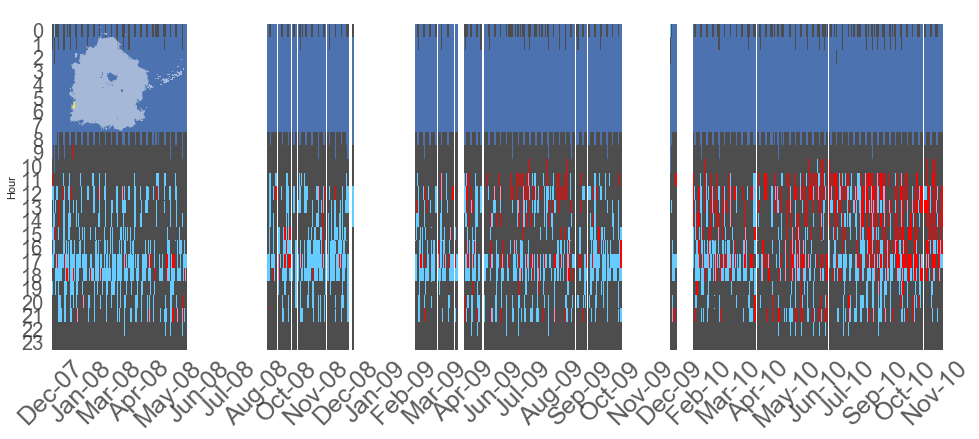

In [29]:
f, ax = plt.subplots(1, figsize=(16, 6))
tools.area_hm('a114', lisas.resample('d', axis=1).mean(), \
              contour=contour, shp=agg, linewidths=0, \
              title=' ', ax=ax, f=f)
plt.savefig('/home/dani/Desktop/andreasplein.png', \
            dpi=300, transparent=True, bbox_inches='tight', \
                        pad_inches=0)